# 03_FuzzyOptionPricing.ipynb

**Course Tutorial Extension**

This notebook extends the ideas from:
- **01_FuzzyControlSystem.ipynb** (fuzzy variables, rules, defuzzification)
- **02_FuzzyClustering.ipynb** (membership and uncertainty representation)

We demonstrate how fuzzy sets can model uncertain inputs such as volatility, interest rate, and dividend yield in the Black–Scholes model.


## 1) Setup & imports




In [2]:
!pip install scikit-fuzzy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 16.0 MB/s eta 0:00:00


In [3]:
import numpy as np
import itertools
from dataclasses import dataclass
from scipy.stats import norm
import matplotlib.pyplot as plt
import skfuzzy as fuzz

plt.rcParams['figure.figsize'] = (9,5)
plt.rcParams['axes.grid'] = True


## 1. Background

In traditional option pricing, the Black–Scholes model assumes precise inputs:
- Volatility (σ)
- Interest rate (r)
- Dividend yield (q)

In reality, these values are **uncertain**.  
We use **fuzzy logic** to model this uncertainty as *fuzzy numbers* and propagate it through the pricing formula.


In [4]:
def d1(S, K, T, r, q, sigma):
    return (np.log(S/K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))

def d2(S, K, T, r, q, sigma):
    return d1(S, K, T, r, q, sigma) - sigma * np.sqrt(T)

def bs_call(S, K, T, r, q, sigma):
    D1 = d1(S, K, T, r, q, sigma)
    D2 = d2(S, K, T, r, q, sigma)
    return S * np.exp(-q*T) * norm.cdf(D1) - K * np.exp(-r*T) * norm.cdf(D2)


## 2. Fuzzy Representation of Volatility Using `skfuzzy`

We define fuzzy sets for volatility using **triangular membership functions** (`fuzz.trimf`).

Each fuzzy set represents our linguistic understanding of volatility:
- *Low*: around 10–18%
- *Medium*: around 14–22%
- *High*: around 18–30%


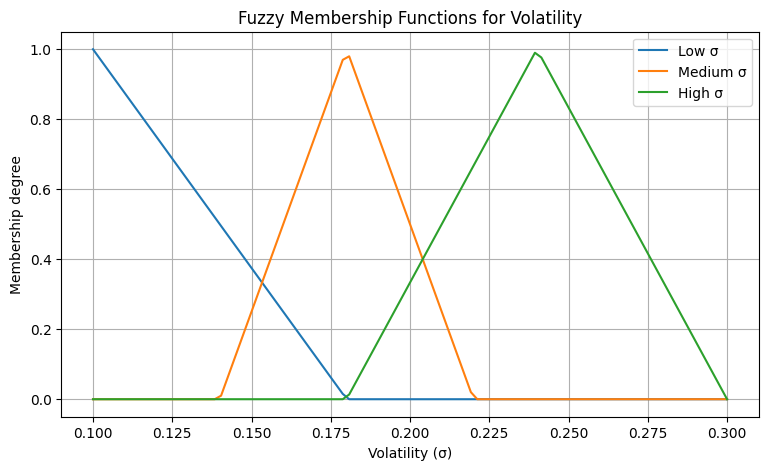

In [5]:
x_sigma = np.linspace(0.1, 0.3, 100)
sigma_low = fuzz.trimf(x_sigma, [0.1, 0.1, 0.18])
sigma_med = fuzz.trimf(x_sigma, [0.14, 0.18, 0.22])
sigma_high = fuzz.trimf(x_sigma, [0.18, 0.24, 0.3])

plt.plot(x_sigma, sigma_low, label='Low σ')
plt.plot(x_sigma, sigma_med, label='Medium σ')
plt.plot(x_sigma, sigma_high, label='High σ')
plt.title('Fuzzy Membership Functions for Volatility')
plt.xlabel('Volatility (σ)')
plt.ylabel('Membership degree')
plt.legend()
plt.show()


## 3. Triangular Fuzzy Numbers and α-Cuts

For simplicity, we still use a small helper class to represent triangular fuzzy numbers.


In [6]:
@dataclass
class TriFuzzy:
    a: float
    m: float
    b: float

    def a_cut(self, alpha):
        lo = self.a + alpha * (self.m - self.a)
        hi = self.b - alpha * (self.b - self.m)
        return lo, hi


## 4. α-Cut Propagation Through Black–Scholes

We propagate fuzzy inputs using the **extension principle**.  
For each α-level, we compute the range of option prices based on the corresponding parameter intervals.


In [7]:
def fuzz_price_band(S, K, T, sigma_fz, r_fz, q_fz, alphas=np.linspace(0,1,11)):
    rows = []
    for a in alphas:
        s_lo, s_hi = sigma_fz.a_cut(a)
        r_lo, r_hi = r_fz.a_cut(a)
        q_lo, q_hi = q_fz.a_cut(a)
        corners = list(itertools.product([s_lo, s_hi], [r_lo, r_hi], [q_lo, q_hi]))
        vals = [bs_call(S, K, T, r, q, s) for s, r, q in corners]
        rows.append([a, np.min(vals), np.max(vals)])
    return np.array(rows)


## 5. Example Run: Fuzzy Black–Scholes

We define fuzzy parameters (volatility, rate, dividend yield) and compute the fuzzy price bands.


In [8]:
S, K, T = 100.0, 100.0, 30/365

sigma_fz = TriFuzzy(0.14, 0.18, 0.24)
r_fz = TriFuzzy(0.018, 0.02, 0.025)
q_fz = TriFuzzy(0.0, 0.005, 0.01)

alphas = np.linspace(0, 1, 11)
bands = fuzz_price_band(S, K, T, sigma_fz, r_fz, q_fz, alphas)

for a, lo, hi in bands:
    print(f"α={a:.1f} → price ∈ [{lo:.4f}, {hi:.4f}]")

midpoints = 0.5 * (bands[:,1] + bands[:,2])
price_defuzz = np.mean(midpoints)
print("\nDefuzzified price:", round(price_defuzz, 4))


α=0.0 → price ∈ [1.6323, 2.8455]
α=0.1 → price ∈ [1.6809, 2.7728]
α=0.2 → price ∈ [1.7296, 2.7001]
α=0.3 → price ∈ [1.7782, 2.6274]
α=0.4 → price ∈ [1.8268, 2.5547]
α=0.5 → price ∈ [1.8754, 2.4820]
α=0.6 → price ∈ [1.9240, 2.4093]
α=0.7 → price ∈ [1.9727, 2.3366]
α=0.8 → price ∈ [2.0213, 2.2639]
α=0.9 → price ∈ [2.0699, 2.1912]
α=1.0 → price ∈ [2.1185, 2.1185]

Defuzzified price: 2.1787


## 6. Visualization: Fuzzy Option Price vs α


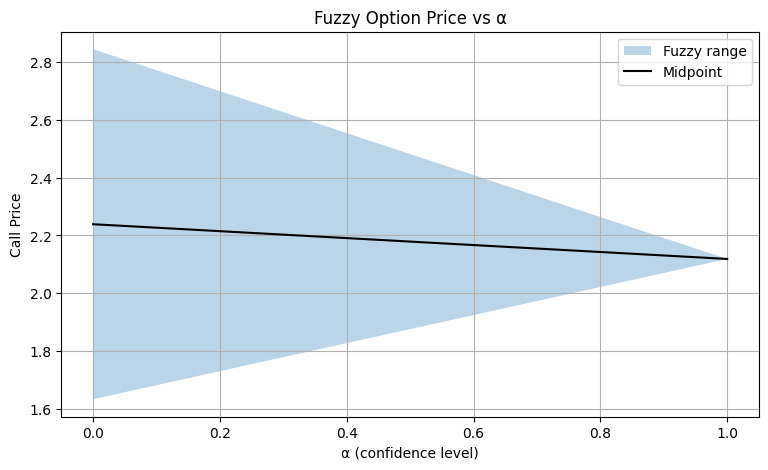

In [9]:
plt.fill_between(bands[:,0], bands[:,1], bands[:,2], alpha=0.3, label='Fuzzy range')
plt.plot(bands[:,0], 0.5*(bands[:,1]+bands[:,2]), color='black', label='Midpoint')
plt.xlabel('α (confidence level)')
plt.ylabel('Call Price')
plt.title('Fuzzy Option Price vs α')
plt.legend()
plt.show()


## 7. Interpretation

- At lower α (less confidence), the range of possible prices is wider.
- At α → 1 (high confidence), the range narrows.
- The defuzzified price provides a single “best estimate.”
- This approach expresses **epistemic uncertainty** — lack of precise knowledge — rather than random noise.


## 9. Reflection and Next Steps

**What this shows:**  
- We can apply fuzzy membership functions to financial uncertainty.  
- α-cut propagation connects the fuzzy control logic to quantitative finance.  
- This extends the `01_FuzzyControlSystem` notebook from rule-based control to analytical pricing.  

**Next Steps:**  
- Use real option chain data (e.g., via `yfinance`) for validation.  
- Calibrate fuzzy spreads empirically from historical volatility data.  
- Compare fuzzy intervals with market bid–ask ranges.  
